<h1 style="text-align: center" >Not every shot is created equal
<h2 style="text-align: center" >Adjusting NHL Corsi statistics for quality of opponent

<h3 style="text-align: center" >DP Rooney
<h3 style="text-align: center" >November 5, 2017

## Introduction and Background


There has been considerable recent growth in advanced statistics for professional hockey. Besides the traditional stats such as goals, assists, and shots on goal, other measures of individual merit have arisen. One popular quantity is the "Corsi-for percentage", or CF%, defined as follows:

$$\textrm{ CF%(player X) } = \frac{\textrm{No. shot attempts for X's team | X on-ice}}{\textrm{No. shot attempts for both teams | X on-ice }} $$

Here, a "shot attempt" is the sum of shots on goal, shots missed, and shots blocked. The CF% stat evaluates how a player contributes to producing shot attempts for his team while preventing shot attempts against his team. Some of the attractive features of this statistic are:

1. It combines offensive and defensive merit, so that players with flashy scoring and frequent defensive lapses are not over-rated.
2. It credits players that contribute indirectly to an offensive play, such as with canny passes from the defensive zone, tight fore-checking, and smart spacing.
3. It eliminates some of the randomness inherent to turning shot attempts into goals.
4. The data set is larger (there are roughly twice as many shot attempts as shots on goal per game).

One major drawback with this stat is that it does not take into account the quality of on-ice opposition. A fundamental phenomenon in hockey is line-matching. Each team has four different forward-lines (and three defense-pairings) that generally differ in abilities, and coaches will strategize as how to optimize the match-ups between opposing lines. For example, a good defensive forward line will often be matched against the opposition's best offensive line. Therefore, comparing the CF% of a first-line and a fourth-line player is unfair to the better player, since he has to work harder to generate a shot attempt, and prevent opposing shot attempts.

For example, this reddit post from 2016 points out that Jake Virtanen, a young, raw prospect for the Vancouver Canucks, has a better CF% than Jonathan Toews, who is seen as one of the best players in the league:

https://www.reddit.com/r/canucks/comments/4omaqp/why_jake_virtanen_is_better_than_jonathan_toews/

While Virtanen may develop into one of the best players in the league, it is unlikely that his performance was on par with Toews' in the 2015-2016 season.

The goal of my project is to develop a model that is more nuanced. Instead of modeling the ratio of shot-attempts as a function of a single player, we will consider the probability of shot-attempts as a function of all players on the ice. In other words, we want to model the probability

$$P(\textrm{ next SA is for home-team } | \textrm{ home-players } X_1, … X_6 \textrm{ on-ice; away-players } Y_1, …, Y_6 \textrm{ on-ice } )$$

My prospective client would be the management of a hockey team that wants to evaluate players in ways that go past the common wisdom. It may want to track the performance of its own players, and also evaluate players that are becoming free agents in the off-season. A predictive model that describes shot-attempt probability relative to opposing players would allow a team to directly compare players and assess their relative value.

Some practical issues:

* I will be considering shot attempts not just in 5-on-5 situations, but also for power play opportunities. Shot attempt difficulty is radically different for the latter situations, but this will be factored into my models. Penalty shots of course, both in-game and in shootouts, are excluded.
* Corsi stats are sometimes separated by "zone starts". Defensive players who usually start their shifts in their own end will be hurt considerably by this. I was unable to obtain the data that separated shot attempts by zone start unfortunately, so my models ignore this factor.
* Goalies will be excluded. Some goalies are better passers and rebound-handlers than others and arguably would affect shot attempts, but I decided to ignore this aspect. 6-on-5 situations, where the goalie is pulled, will be considered power play situations.

## Scraping and Wrangling

The data used is from the 2015-2016 season. It was scraped from three types of game reports from the NHL: game rosters, event summaries, and play-by-play reports. Unfortunately, the HTML pages have been re-named, and re-formatted, so that the scraper will no longer work. But the data was scraped before this happened.

The defunct URL's for the first game are:

http://www.nhl.com/scores/htmlreports/20152106/RO020001.HTM

http://www.nhl.com/scores/htmlreports/20152106/ES020001.HTM

http://www.nhl.com/scores/htmlreports/20152106/PL020001.HTM

The two-letter codes RO, ES and PL indicate the report type (roster, event, play), and the last four digits of the six-digit sequences indicate the game number (the first two digits distinguish pre-season (01), regular season (02) and post-season (03)). There were 1230 game in the 2015-2016 regular season (30 teams and 82 games each). These reports were all in pure HTML (no CSS or JSON), so I had to go through a lot of nested ```<table>```'s to get the necessary data. For comparison, the new game report can be seen here:

https://www.nhl.com/gamecenter/tor-vs-ott/2016/10/12/2016020001#game=2016020001,game_state=final

I have decided not to include any code in this report, as I used quite a lot of Python. In the appendix, I have listed all the files with Python code contained in the github repository:

https://github.com/darraghrooney/Springboard_Capstone

In this section I will give an overview of the files I used to form my data sets.

In [1]:
import os
import numpy as np
import scipy.stats as sps 
import pandas as pd

from sklearn.linear_model import LinearRegression, LogisticRegression

%matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import plotting.plotting as myplot

Using matplotlib backend: Qt5Agg


The `scraping` folder contains six files for scraping the data:

1. The file `roster_scrape.py` contains code for scraping the roster reports. It includes a class `RosterParse` which extracts the forty players that dressed (eighteen players and two goalies for each team). This includes their team, the player name, the position (center, left wing, right wing, defense or goalie) and their jersey number. A second class, `RosterBuilder` assembled rosters for all 1230 games and saved them in a 49,200 line file `Big_Roster.csv`. 

2. The file `directory_build.py` contains code for consolidating the big roster into a player directory, saved in `Directory.csv`. It includes a class `SalaryParse` that extracts the salary for each player from the web-site www.capfriendly.com. The class `DirectoryBuilder` constructs the player directory and adds the salary information. The player directory contains 1,011 players, of which 111 are goalies.

3. The file `salary_fill.py` contains code for filling in some missing salary information that was not immediately available from CapFriendly. 25 players did not have 2015-2016 salaries available, so I used their 2016-2017 salaries. Salaries are only being used to estimate perception of player quality, so using salary from two different years is not such a big deal.

4. The file `report_downloader.py` contains code for downloading the play-by-play and event summary reports. I used this because I wanted to work on scraping while off-line.

5. Besides salary information, I also wanted to use time-on-ice (TOI) information. The file ```es_scrape.py``` includes code for doing this. It includes a class `EventParse` that looks at the event-summary reports and extracts TOI for each player for each game, and a class `TOIBuilder` which totals season TOI and adds it to the player directory. It also includes a function `Dir_process` which adds a column `paTOI/G` to the directory. This statistic is the per-game TOI for each player, multiplied by 0.75 if the player is a defensemen. Because there are 3 defense lines to 4 forward lines, defensemen play approximately 4/3 as much, so TOI/G should be adjusted.

6. The file `attempt_scrape.py` contains code for extracting the shot-attempt data for each game and saving it as a table. These tables include 14 columns: the event (shot, missed shot, goal, blocked shot), a boolean stating whether the attempt was for the home teams, the jersey numbers for the six home player and six away players (some of which would be listed as `None` if there were penalties). Note: these tables are not in the repo, as I combined them in the wrangling process and discarded them.

Here is a sample of the player directory in `Directory.csv`. Note goalies do not have a TOI, so there is a NaN recorded there:

In [2]:
df = pd.read_csv('data/Directory.csv')
df.head()

,ID,Player,Position,Games Dressed,Salary,TOI,paTOI/G
0,1,AARON DELL,G,2,575000,NaN,NaN
1,2,AARON EKBLAD,D,78,925000,1690.816667,16.257853
2,3,AARON NESS,D,8,575000,99.100000,9.290625
3,4,ADAM CLENDENING,D,29,761250,429.083333,11.096983
4,5,ADAM CRACKNELL,R,52,575000,636.016667,12.231090


There is still work to be done however. In a separate folder `wrangling`, I have three files for further data handling. I'll talk about the third in the next section. The other two are:


1. `attempt_manager.py` is responsible for consolidating the shot-attempt data into one data set. It contains a class `attempt_manager` that does this. It saves a number of objects into the file `Attempts.npz`. First and foremost, it contains a 0-1 sparse matrix (a `csc_matrix` object from the module `scipy.sparse`) with 1800 columns and 136,530 rows. Each row represents one shot attempt, and each column represents one player, and each element is `True` if and only if that player was on the ice for that shot attempt. There are 1800 columns because there are 900 players (we exclude the goalies) and we consider a player at-home to be distinct from a player away-from-home, so columns 1-900 are home players and 901-1800 away players. 

    The sparse matrix is our main data set, but some other objects are also contained in the file:
    * the list of non-goalie names so that we can match the columns to players
    * game counts: the number of shot attempts in each game
    * a list of indices indicating which of the shot attempts was for the home team. This is our indicator variable.
    * a list of attempt type (whether an attempt was a goal, shot, missed shot, or blocked shot).
    * four lists indicating the average salary and average playing time of the players on-ice for the home and away sides

   The class also contains a method `compute_Corsi` which computes the season CF for any player.

2. The file `summary_manager.py` is for looking at attempt data on a game-by-game basis. It includes a class `summary_manager` which adds the goals, shots, missed shots, blocked shots and total shot attempts for each team in each game and saves it in the file `Summary.csv` as a 1230 by 10 table.

Here is a sample of the Summary data:

In [3]:
summ_df = pd.read_csv('data/Summary.csv')
summ_df.head()

,Home goals,Home shots,Home misses,Home blocks,Home Corsi,Away goals,Away shots,Away misses,Away blocks,Away Corsi
0,1,36,14,15,66,3,26,16,9,54
1,2,32,14,15,63,3,24,11,3,41
2,1,29,11,13,54,5,39,11,10,65
3,1,19,11,13,44,5,27,12,10,54
4,2,29,19,13,63,6,26,9,9,50


## A first look at the data

First note that we have lots of data to work with. There were 136,530 shot attempts in the 2015-2016 season and 900 players (i.e. 1800 features):

In [4]:
import wrangling.attempt_manager as am

AM = am.attempt_manager()
AM.Load()
print('Number of non-goalies that dressed in 2015-16: {}'.format(len(AM.NGs)))

t_dict = {'G': 'Goals', 'S': 'Shots saved', 'M': 'Shot missed', 'B': 'Shots blocked'}

for k in t_dict.keys():
    print(t_dict[k] + ': ' + str(AM.attempt_type.count(k)))
print('Total shot attempts: {}'.format( AM.no_att )) 

Number of non-goalies that dressed in 2015-16: 900
Shots saved: 66601
Goals: 6565
Shots blocked: 34845
Shot missed: 28519
Total shot attempts: 136530


We can ask how many data points we have for each player. It turns out the average is over 700. However, the spread is quite large (over 70 precent of the mean), and 12.7 percent of players have fewer than 50:

Mean of player on-ice shot attempts: 740.4744444444444
Median: 737.5
Standard deviation: 547.8564539886445
Fraction of players with 50 or fewer: 0.127222222222


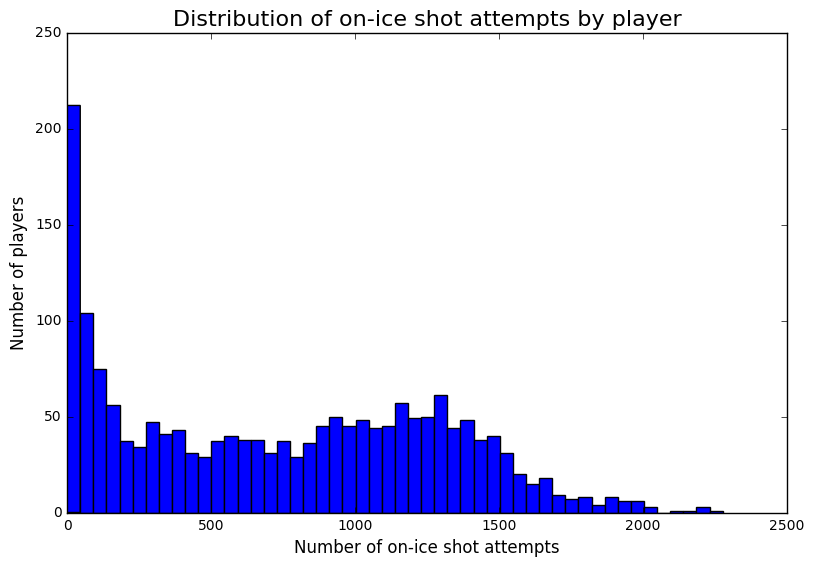

In [5]:
pl_atts = list()
for k in range(0,1800):
    pl_atts.append(AM.att_matrix.getcol(k).nnz)

print('Mean of player on-ice shot attempts: ' + str(pd.Series(pl_atts).mean()))
print('Median: ' + str(pd.Series(pl_atts).median()))
print('Standard deviation: ' + str(pd.Series(pl_atts).std()))
print('Fraction of players with 50 or fewer: '+ str(pd.Series(pl_atts)[pd.Series(pl_atts) < 51].count()/1800))

fig = plt.figure()
ax = fig.add_axes([.1,.1,1.2,1.2])
plt.xlabel('Number of on-ice shot attempts', fontsize = 12)
plt.ylabel('Number of players', fontsize = 12)
plt.title('Distribution of on-ice shot attempts by player', fontsize = 16)
ax.hist(pl_atts,bins=50)
plt.show()

Note that in the foregoing, we are considering player X at home to be different than the same player away from home. This is because there is a clear home-ice advantage, in terms of goals and shot attempts, as seen below. So for the extent of this report, we will keep all 1,800 features, rather than attempt to combine them into 900.

In [6]:
print('Home goals: {}'.format( sum( pd.Series( AM.attempt_type)\
        [AM.home_indices] == 'G') ))
print('Away goals: {}'.format(AM.attempt_type.count('G') - \
        sum( (pd.Series( AM.attempt_type)[AM.home_indices] == 'G') )))

print('Home shot attempts: {}'.format(len(AM.home_indices)))
print('Away shot attempts: {}'.format( AM.no_att - len(AM.home_indices) ))

Home goals: 3404
Away goals: 3161
Home shot attempts: 70468
Away shot attempts: 66062


Admittedly, the mean home-ice advantage is not very large compared to the variance:

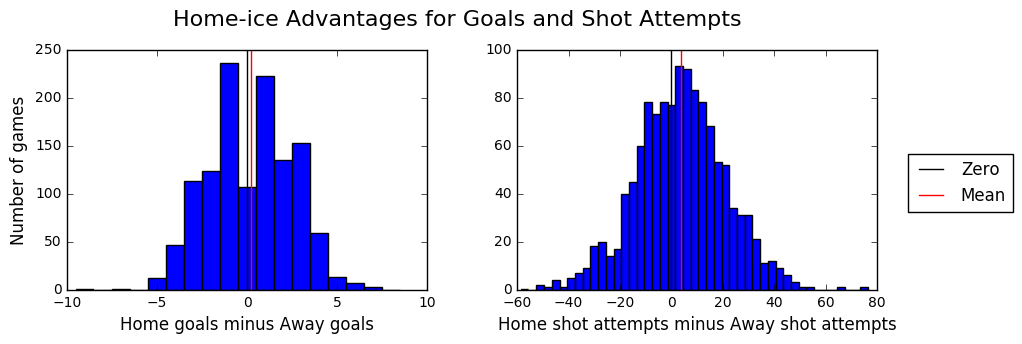

In [7]:
import matplotlib.lines as mlines

goal_diff = summ_df.loc[:,"Home goals"]-summ_df.loc[:,"Away goals"]
Corsi_diff = summ_df.loc[:,"Home Corsi"]-summ_df.loc[:,"Away Corsi"]

fig = plt.figure()
ax1 = fig.add_axes([.1,.1,0.6,0.6])
ax2 = fig.add_axes([.85,.1,0.6,0.6])
ax1.hist(goal_diff, bins=np.arange(-9.5,9.5,1))
ax2.hist(Corsi_diff, bins=np.arange(-58.5,79.5,3))
ax1.axvline(x=0, color="black")
ax1.axvline(x=goal_diff.mean(), color="red")
ax2.axvline(x=0, color="black")
ax2.axvline(x=Corsi_diff.mean(), color="red", label="Mean")
fig.suptitle('Home-ice Advantages for Goals and Shot Attempts', fontsize=16, x=0.75, y=.8)
ax1.set_xlabel('Home goals minus Away goals', fontsize=12)
ax2.set_xlabel('Home shot attempts minus Away shot attempts', fontsize=12)
ax1.set_ylabel('Number of games', fontsize=12)
black_line = mlines.Line2D([], [], color='black', label='Zero')
red_line = mlines.Line2D([], [], color='red', label='Mean')
plt.legend(handles=[black_line, red_line], bbox_to_anchor=[1.4,.6])
plt.show()

Note that the number of games with zero differential in terms of goals is lower than surrounding values. This is because the 5-minute overtime reduces the incidence of such games (we are counting shoot-out games as "ties").

Home-ice advantange appears to be worth about 0.2 goals every game, and 3.6 shot attempts per game. Are these significant though? We see below that, despite the proximity of the red and black lines above, the effects are significant. Interestingly, the statistical significance is much higher for shot attempts than goals. 

It is debatable whether the effect size is too small to matter. The effects do not look large in the above histograms. Nevertheless, most hockey people would love to have a 0.2 goal advantange (on average).

In [8]:
z_statistic = goal_diff.mean()/(goal_diff.std()/np.sqrt(len(goal_diff)))
print('Mean home-ice advantage for goals: {}'.format(goal_diff.mean()))
print('The z-score is: {}'.format(z_statistic))
print('The probability that this is just a fluke is: {}'.format(1-sps.norm.cdf(z_statistic)))

Mean home-ice advantage for goals: 0.1975609756097561
The z-score is: 2.9924034493916203
The probability that this is just a fluke is: 0.001383951020791363


In [9]:
z_statistic = Corsi_diff.mean()/(Corsi_diff.std()/np.sqrt(len(Corsi_diff)))
print('Mean home-ice advantage for shot attempts: {}'.format(goal_diff.mean()))
print('The z-score is: {}'.format(z_statistic))
print('The probability that this is just a fluke is: {}'.format(1-sps.norm.cdf(z_statistic)))

Mean home-ice advantage for shot attempts: 0.1975609756097561
The z-score is: 7.258237461098951
The probability that this is just a fluke is: 1.9606538614880265e-13


Now let us turn to the relationship between goals and shot attempts. Games are won by the former, after all. As it turns out, the correlation is actually slightly negative!

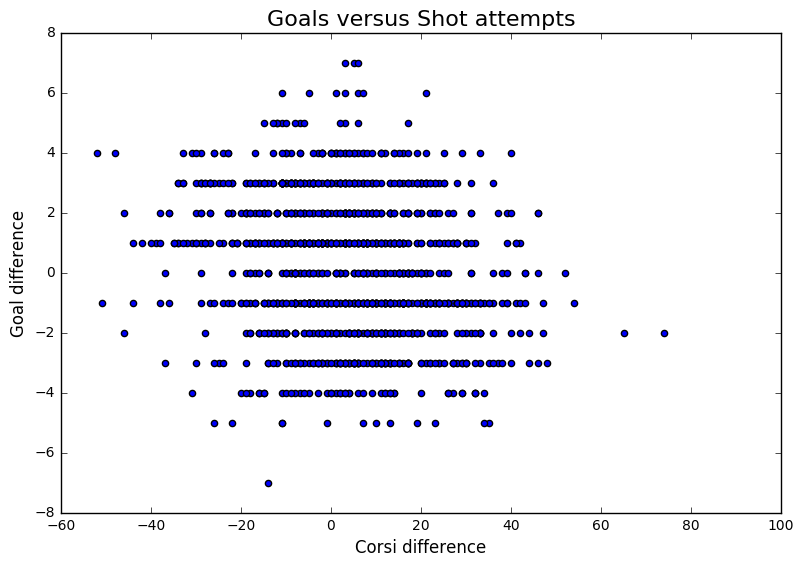

In [10]:
import wrangling.summary_manager as sm

SM = sm.summary_manager()
SM.Load()
goal_diff = SM.summary['Home goals'] - SM.summary['Away goals']
Corsi_diff = SM.summary['Home Corsi'] - SM.summary['Away Corsi'] 

fig = plt.figure()
ax = fig.add_axes([.1,.1,1.2,1.2])
plt.xlabel('Corsi difference', fontsize = 12)
plt.ylabel('Goal difference', fontsize = 12)
plt.title('Goals versus Shot attempts', fontsize = 16)
ax.scatter(Corsi_diff, goal_diff)
plt.show()

In [11]:
LR = LinearRegression()
LR.fit( Corsi_diff.reshape(-1,1),goal_diff.reshape(-1,1))
print('Regression coefficient: {}'.format(LR.coef_[0,0]))

Regression coefficient: -0.026606973456951434


There are ways to explain this. First of all, goalie skill is of course a factor in converting shot attempts into goals. More importantly, teams that score early and obtain a lead often sit back and allow their opponent to take poor-quality shots. A more nuanced analysis would take a deeper look at this effect. We are more concerned with using the stat as a indicator of player performance, not of team performance, so we shall move on.

We can use two proxy statistics to assess 'quality of opponent' (or at least the perception of quality): player salary and average playing time. Salary is a little problematic, because younger players are certainly underpaid, and the production of older players can fall off after getting a fat contract. So salary and quality do not correlate as much as we would like. The latter statistic is probably better, because a coach can respond quickly to changes in playing quality, and because there is a decent spread in player time on ice (TOI):

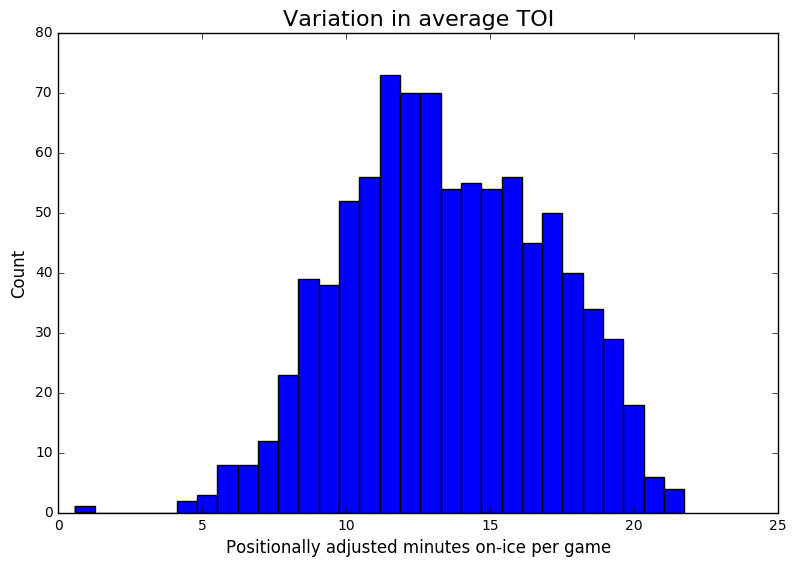

In [12]:
players = pd.read_csv('data/Directory.csv')
players=players[ ~players.TOI.isnull()]
fig = plt.figure()
ax = fig.add_axes([.1,.1,1.2,1.2])

plt.hist( list(players['paTOI/G']),bins=30)
plt.xlabel('Positionally adjusted minutes on-ice per game', fontsize =12)
plt.ylabel('Count', fontsize =12)
plt.title('Variation in average TOI', fontsize = 16)
plt.show()

If playing time and salary are both good measures of player quality, we should expect them to correlate:

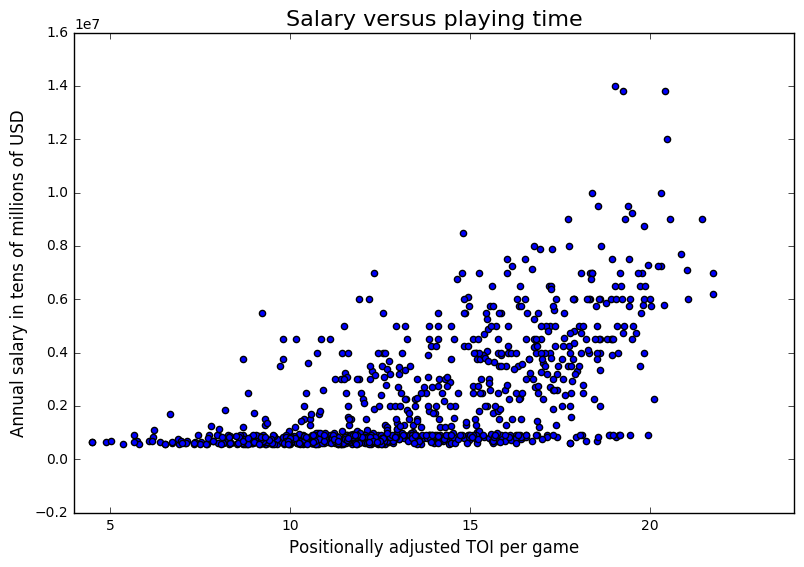

In [13]:
fig = plt.figure()
ax = fig.add_axes([.1,.1,1.2,1.2])
plt.scatter(players['paTOI/G'],players['Salary'])
plt.xlim(4,24)
plt.xlabel('Positionally adjusted TOI per game', fontsize =12)
plt.ylabel('Annual salary in tens of millions of USD', fontsize =12)
plt.title('Salary versus playing time', fontsize = 16)
plt.show()

We see a clear correlation, although we can see a subgroup that is rather flat at the bottom. As it happens, entry-level contracts are capped at 925,000 USD, so that subgroup represents the underpaid young players. 

To support our claim that better players tend to share the ice with other better players, we consider the average salary and playing time for home players versus away players. ```attempt_manager``` has class variables recording this data.

Visually it's difficult to tell whether there's a good correlation, especially with respect to salary:

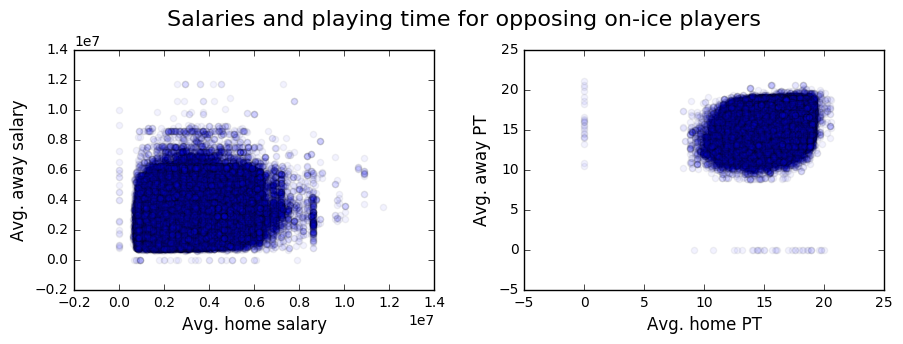

In [14]:
myplot.sal_PT_plot()

If we run a linear regression however, we can see that, after proper scaling, there is a moderate salary correlation:

In [15]:
import wrangling.attempt_manager as am

AM = am.attempt_manager()
AM.Load()

h_sal = pd.Series(AM.home_OI_sal)
a_sal = pd.Series(AM.away_OI_sal)
h_PT = pd.Series(AM.home_OI_PT)
a_PT = pd.Series(AM.away_OI_PT)

h_sal_norm = (h_sal-h_sal.mean())/h_sal.std()
a_sal_norm = (a_sal-a_sal.mean())/a_sal.std()

LR = LinearRegression()
LR.fit(h_sal_norm.reshape(-1,1),a_sal_norm.reshape(-1,1))
print('Correlation of home on-ice salary to away on-ice salary: {}'.format(LR.coef_[0,0]))

Correlation of home on-ice salary to away on-ice salary: 0.14216013948400255


And when we do the same to the playing time data, we get a correlation coefficient of 0.30. This is around what I would expect: a definite correlation, but enough 'cross-talk' between various lines that we get good players on the ice with not-so-good players at a reasonable clip.

In [16]:
h_PT_norm = (h_PT-h_PT.mean())/h_PT.std()
a_PT_norm = (a_PT-a_PT.mean())/a_PT.std()

LR1 = LinearRegression()
LR1.fit(h_PT_norm.reshape(-1,1),a_PT_norm.reshape(-1,1))
print('Correlation of home on-ice PT to away on-ice PT: {}'.format(LR1.coef_[0,0]))

Correlation of home on-ice PT to away on-ice PT: 0.29567157178338255


We can now ask whether these two metrics affect shot attempts:

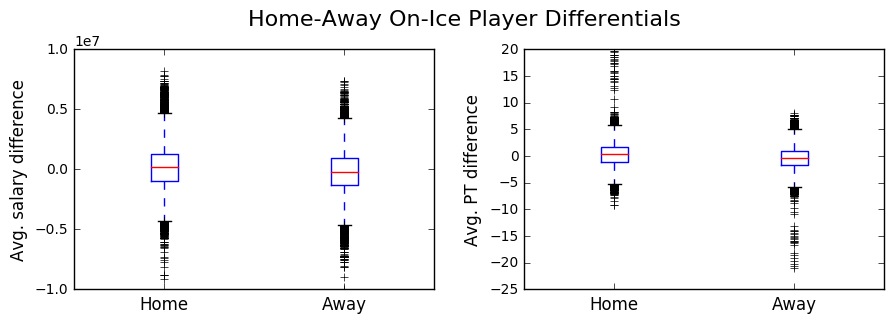

In [17]:
myplot.OI_diff_plot()

It is clear that effect size is actually quite small, and in the case of salary, there may not be any effect at all. Despite the very significant overlap in both cases, our sample size is very large, so we may get very large z-statistics anyway. 

In [18]:
AM = am.attempt_manager()
AM.Load()
away_indices = list(set(range(0,len(AM.attempt_type))) - set(AM.home_indices))
away_indices.sort()
sal_diff = pd.DataFrame()
sal_diff_home = list(pd.Series(AM.home_OI_sal)[AM.home_indices]- \
                     pd.Series(AM.away_OI_sal)[AM.home_indices])
sal_diff_away = list(pd.Series(AM.home_OI_sal)[away_indices] - \
                     pd.Series(AM.away_OI_sal)[away_indices])

sal_diff_mean_diff = np.mean(np.array(sal_diff_home)) - np.mean(np.array(sal_diff_away))
sal_diff_var_home = np.var(np.array(sal_diff_home))
sal_diff_var_away = np.var(np.array(sal_diff_away))
nh = len(sal_diff_home)
na = len(sal_diff_away)
sal_diff_error = np.sqrt( 1/ float(nh)+1/float(na)) * np.sqrt( (nh*sal_diff_var_home + nh*sal_diff_var_away)/ float(nh+na-2))

z_statistic = sal_diff_mean_diff / sal_diff_error
print('Difference in salary discrepancy between home and away shot attempts: {}'.format(sal_diff_mean_diff))
print('The z-score is: {}'.format(z_statistic))
print('The probability that this is just a fluke is: {}'.format(1-sps.norm.cdf(z_statistic)))

Difference in salary discrepancy between home and away shot attempts: 426308.743591288
The z-score is: 44.959248570399794
The probability that this is just a fluke is: 0.0


In [19]:
PT_diff_home = pd.Series(AM.home_OI_PT)[AM.home_indices] - \
                     pd.Series(AM.away_OI_PT)[AM.home_indices]
PT_diff_away = pd.Series(AM.home_OI_PT)[away_indices] - \
                     pd.Series(AM.away_OI_PT)[away_indices]
PT_diff_mean_diff = np.mean(np.array(PT_diff_home)) - np.mean(np.array(PT_diff_away))
PT_diff_var_home = np.var(np.array(PT_diff_home))
PT_diff_var_away = np.var(np.array(PT_diff_away))
nh = len(PT_diff_home)
na = len(PT_diff_away)
PT_diff_error = np.sqrt( 1/ float(nh)+1/float(na)) * np.sqrt( (nh*PT_diff_var_home + nh*PT_diff_var_away)/ float(nh+na-2))

z_statistic = PT_diff_mean_diff / PT_diff_error
print('Difference in playing time discrepancy between home and away shot attempts: {}'.format(PT_diff_mean_diff))
print('The z-score is: {}'.format(z_statistic))
print('The probability that this is just a fluke is: {}'.format(1-sps.norm.cdf(z_statistic)))

Difference in playing time discrepancy between home and away shot attempts: 0.6652949318987651
The z-score is: 57.9543230745336
The probability that this is just a fluke is: 0.0


Both of the effect sizes (average salary bump of $436,000 and playing time bump of 36 seconds per 60 minutes) are rather small but definitely not trivial. Additionally, the large sample sizes allow us to conclude that these effects are very significant. If salary and playing time are good indicators of player ability, then the ability of players on the ice affects frequency of shot attempts. 

We have already mentioned that playing time is probably a better indicator of player ability than salary. Moreover, both variables are correlated, so is it necessary to consider both? More variables lead to overfitting and we don't want two features when only one is needed. 

Now, one can imagine reasons why salary could still be useful. Some older players may be quite skilled but with lower stamina. Therefore they may be well compensated, but given less playing time. A more important effect is that players on bad teams get more playing time than they deserve, because their competition is limited. Presumably their salary would not reflect this lower competition. Conversely, players on loaded teams may be well-paid to reflect their ability, but may see less ice-team because their teammates are good. This effect is probably mitigated considerably by the salary cap, but let us examine the data.

Let's create a third feature by projecting away PT from the salary data. Define adjusted salary to be:
$$\textit{adjusted salary = salary -  ( PT-salary correlation) * (playing time) }$$

In [20]:
numerator1 = np.matrix(AM.home_OI_sal).dot(np.matrix(AM.home_OI_PT).T )[0,0]
denom1 = np.matrix(AM.home_OI_PT).dot(np.matrix(AM.home_OI_PT).T )[0,0]
adj_sal_home = np.matrix(AM.home_OI_sal) - numerator1/denom1 * np.matrix(AM.home_OI_PT)

numerator2 = np.matrix(AM.away_OI_sal).dot(np.matrix(AM.away_OI_PT).T )[0,0]
denom2 = np.matrix(AM.away_OI_PT).dot(np.matrix(AM.away_OI_PT).T )[0,0]
adj_sal_away = np.matrix(AM.away_OI_sal) - numerator2/denom2 * np.matrix(AM.away_OI_PT)

adj_sal_diff_home = np.array(adj_sal_home)[0][AM.home_indices] - np.array(adj_sal_away)[0][AM.home_indices]
adj_sal_diff_away = np.array(adj_sal_home)[0][away_indices] - np.array(adj_sal_away)[0][away_indices]

adj_sal_diff_mean_diff = np.mean(adj_sal_diff_home) - np.mean(adj_sal_diff_away)
adj_sal_diff_var_home = np.var(adj_sal_diff_home)
adj_sal_diff_var_away = np.var(adj_sal_diff_away)
nh = len(adj_sal_diff_home)
na = len(adj_sal_diff_away)
adj_sal_diff_error = np.sqrt( 1/ float(nh)+1/float(na)) * np.sqrt( (nh*adj_sal_diff_var_home + nh*adj_sal_diff_var_away)/ float(nh+na-2))

z_statistic = adj_sal_diff_mean_diff / adj_sal_diff_error
print('Difference in adjusted salary discrepancy between home and away shot attempts: {}'.format( adj_sal_diff_mean_diff))
print('The z-score is: {}'.format(z_statistic))
print('The probability that this is just a fluke is: {}'.format(1-sps.norm.cdf(z_statistic)))

Difference in adjusted salary discrepancy between home and away shot attempts: 285534.7842569862
The z-score is: 34.94615612878633
The probability that this is just a fluke is: 0.0


So, the adjustment decreases the effect size, by slightly less than half. Yet the confidence in a significant result is still extremely high. The large sample size has lot to do with this, but as of now, the data indicates we should keep both variables.

## Basic models

The first step is to use a logistic regression. We will look at three simple models:

1. A logistic regression that just uses the Corsi numbers of the home and away players. The correct features are not the CF% numbers themselves, but the logarithms thereof. Additionally, we are not going to use the *averages*, but the sum. The reason is that power play situations mean that the number of players on-ice are not constant, and this certainly affects the shot attempts. Therefore, our first two variables are $x_1 = \sum_{i, X_i \textrm{ on-ice }} \log(CF\%(X_i))$ and $x_2 = \sum_{i, Y_i \textrm{ on-ice }} \log(CF\%(Y_i))$, where $X_i$ and $Y_i$ represent home and away players, respectively. 
    
2. A logistic regression that adds two more variables: $x_3$ and $x_4$, the average playing-time of the home on-ice players and the away on-ice players.

3. A logistic regression that adds another two variables: $x_5$ and $x_6$, the average salary of the home on-ice players and the away on-ice players.

First, to properly evaluate our models, we need to make a training / cross-validation split. We have some code in the file `data_split.py` that does this. Sixty percent of our data set is sent to the file `Training.npz` to be use to train our algorithm. The split is done randomly (and seeded properly). The remaining data are split evenly and sent to `CPV.npz` and `Test.npz`.  

After we obtain our training set, we must reduce our data set to the six desired features. We have code in the file `feature_assemble.py` that accomplishes this. It contains a class `FeatureAssemble`, which includes methods `Corsis()` and `Assemble()`. The former computes the CF% stats, but only using the shot attempts in the training set, and the latter constructs a table containing $x_1$ through $x_6$. 

One practical issue that should be noted: since we are using log-likelihoods, any CF% that is 0 or 100 will cause an error. This is not an issue for most players, but for players that have little data available, we must use a fudge factor $\epsilon$, and insist that every player is on the ice for at least $\epsilon$ shot attempts in either direction. In our code we use $\epsilon=0.1$, so that a player that is on the ice for only one shot attempt has a $CF\%$ of either 9.09% or 90.9%. This also means a player who sees zero shot attempts has a CF% of exactly 50%.

Now that we have constructed our data, we code a logistic classifier object `small_logistic`, contained in the file `small_logistic.py`. This object first scales the data (this is important, as salary is much larger in scale than playing time), and then fits the data three times. First using only $x_1$ and $x_2$, second adding $x_3$ and $x_4$, and third adding $x_5$ and $x_6$. It can also compute the prediction score and cross-entropy of the trained classifier on both the training and cross-validation data. We use another object called `SL_sweeper` that varies the regularization strength (actually the parameter is $C$, the inverse of the regularization strength):

In [21]:
import warnings 
warnings.filterwarnings('ignore')

import small_logistic.small_logistic as slr

C = [ pow(10, c/2.) for c in range(-10,10)]
SLS = slr.SL_sweeper(C)
SLS.training()

Now that we have trained the algorithm, we can display the learning curves. The four graphs below show the prediction score (left) and cross-entropy (right) as $C$ varies, for all three methods. The lower graphs are identical to upper graphs, but with the vertical scale magnified, so that we can see the separation of the three algorithms: 

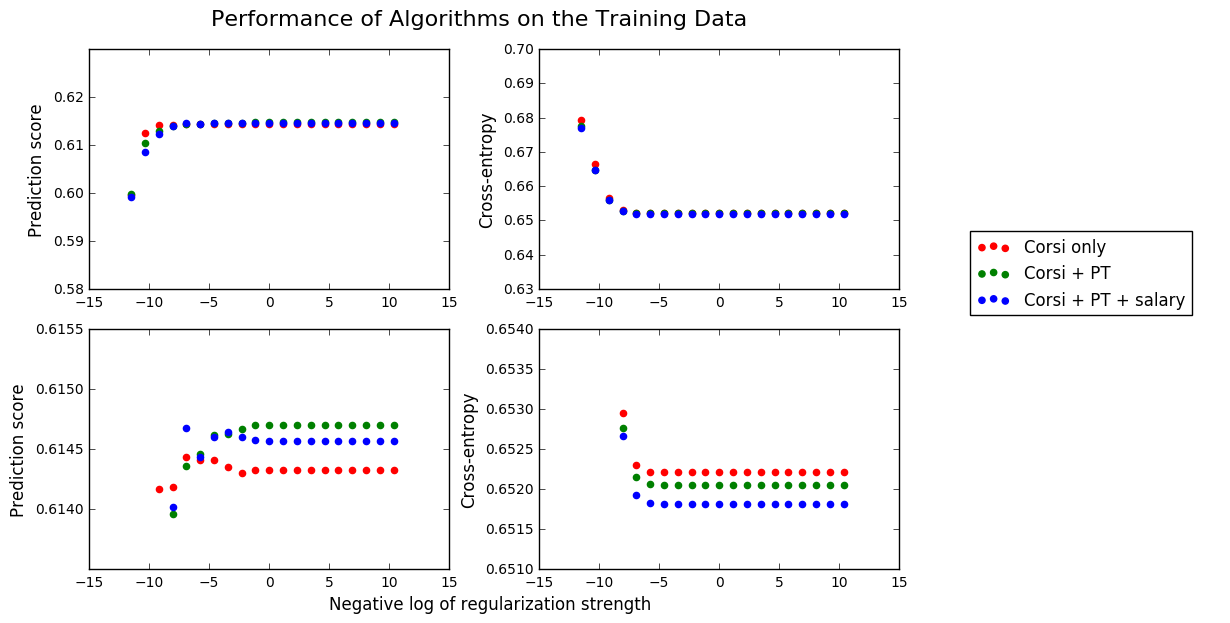

In [22]:
import plotting.small_log_plot as slp
slp.train_plot(SLS)

Here is how the algorithms fare on the cross-validation data:

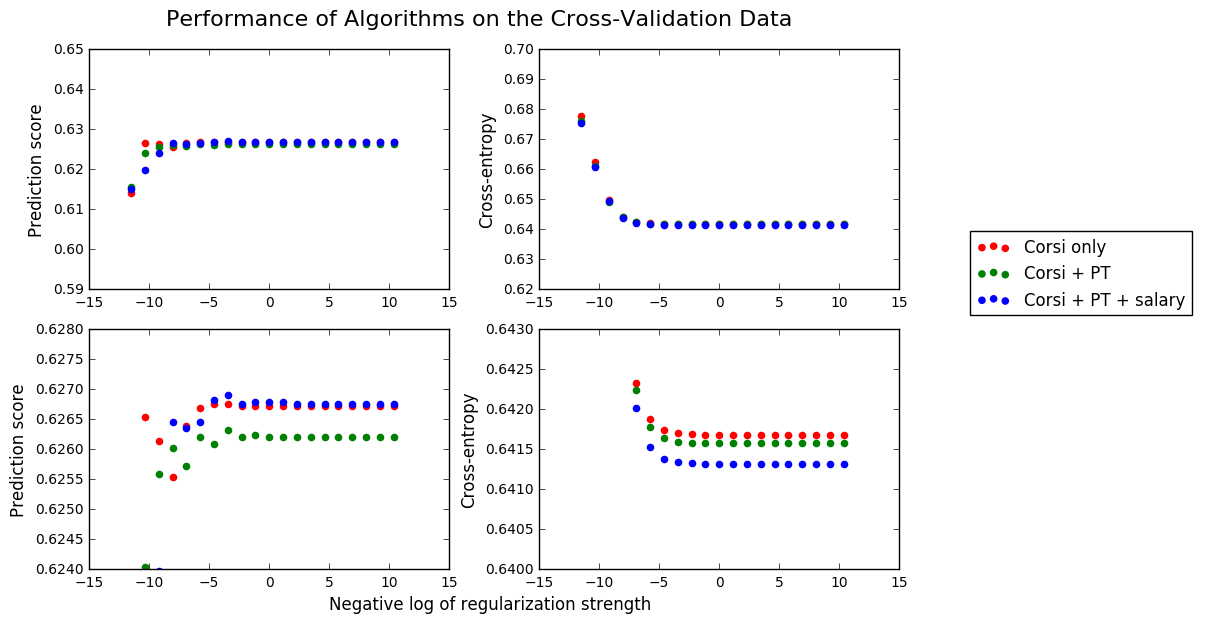

In [23]:
slp.cv_plot(SLS)

If we pick the algorithm that performs best, and choose the best $C$, these are our performance metrics:

In [24]:
best_C = SLS.eval_matrix['all','CV','Cross entropy'].argmin()
SLS.eval_matrix.loc[best_C,'all']

split     metric       
Training  Scores           0.614566
          Cross entropy     0.65181
CV        Scores           0.626749
          Cross entropy    0.641316
Name: 31622.7766017, dtype: object

Some observations:

1. We must admit that the improvement we get by adding salary and PT is very small (so small that we needed to magnify). Ultimately, this has to be somewhat disappointing.
2. The prediction score using just the Corsi numbers however is not that bad. This is an inherently noisy process, so we do not expect do get anywhere near to even 90% prediction score. Getting above 60% is rather satisfying. Clearly, we have some predictive power.
3. Judging by cross-entropy on the training and cross-validation sets, adding PT improves our model, and adding salary improves it even more. Interestingly, these improvements do not necessarily carry over to the prediction score. Adding salary hurts the prediction score on the training set, while on the cross-validation set, the Corsi + PT model performs the worst! Ultimately, we have to judge our model on cross-entropy rather than prediction score.
4. Strangely, our metrics are slightly better on the cross-validation data! Presumably, this is because of a smaller data set (although of course we are using average cross-entropy).
5. The cross-validation learning curves do not really a show an optimum: the performance does not suffer by eliminating regularization.

We can conclude from 4. and 5. that we are definitely not over-fitting our algorithms. Combining that with the disappointing improvement indicates we need to implement more powerful models. 

## Logistic regression with 1800 features

The models described so far are quite basic, and more sophistication is required.  The obvious next step is to implement a logistic classifier that uses all 1800 features. Presumably the much larger feature space will allow us to build a better classifier.

We use an object `big_logistic` in the file `big_logistic/big_logistic.py` which is similar to `small_logistic`. Actually, it is simpler, since we have one rather than three models. Additionally, we don't need to scale the training set, since all of our feature variables are binary. We also have an object `BL_sweeper` which sweeps across a list of regularization constants.

In [25]:
import big_logistic.big_logistic as blr

C = [ pow(10, c/4.) for c in range(-20,20)]
BLS = blr.BL_sweeper(C)
BLS.training()

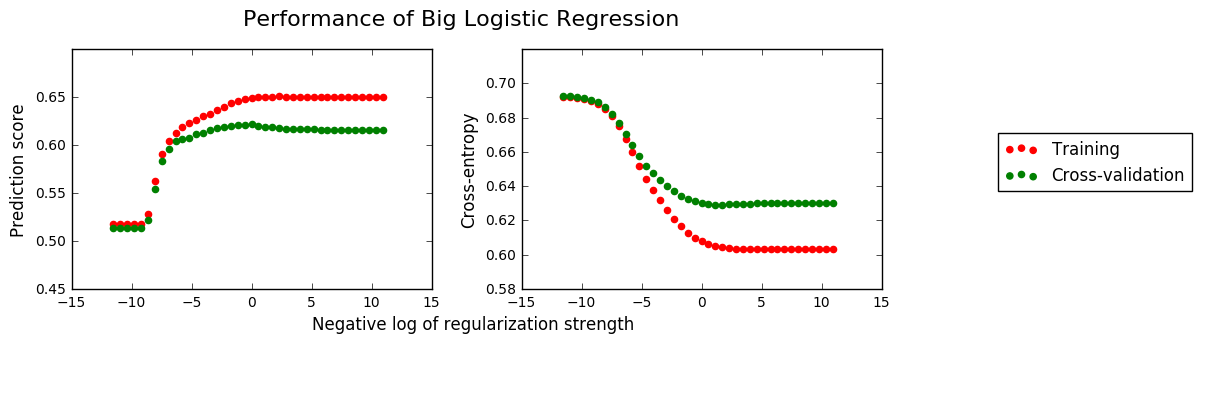

In [26]:
import plotting.big_log_plot as blp

blp.comp_plot(BLS)

What we can observe:

1. Performance on the training set is noticeably improved. Peak prediction score has increased from around 61.5 to 65 percent. Cross-entropy has decreased from around 0.65 to 0.60. 
2. We begin to see the hallmark characteristics of learning curves: there is considerable separation between training and cross-validation as regularization is removed. Additionally, we can detect an optimum in the cross-validation curve (it is somewhat harder to see on the right, but there is a minimum).
3. The bottom-line is that the cross-entropy of the algorithm on the cross-validation set has improved. It is certainly a moderate improvement: 

In [28]:
print('Optimal cross-validation accuracy using 6 features: {}'.\
    format(SLS.eval_matrix['all','CV','Scores'].max()))
print('Optimal cross-validation accuracy using 1800 features: {}'.\
    format(BLS.eval_matrix['CV','Scores'].max()))
print('Optimal cross-validation cross-entropy using 6 features: {}'.\
    format(SLS.eval_matrix['all','CV','Cross entropy'].min()))
print('Optimal cross-validation cross-entropy using 1800 features: {}'.\
    format(BLS.eval_matrix['CV','Cross entropy'].min()))

Optimal cross-validation accuracy using 6 features: 0.6268951878707977
Optimal cross-validation accuracy using 1800 features: 0.6217314875851461
Optimal cross-validation cross-entropy using 6 features: 0.6413161525631554
Optimal cross-validation cross-entropy using 1800 features: 0.6292112955640586


Nevertheless, we can conclude that our logistic classifier performs better than the previous basic models.

## Random Forests

We would like an algorithm that has more significant improvement than the logarithmic regression used above. Neural networks and support vector machines are a possibility, but perhaps 

In [29]:
import forests.rafo as rf

depths = [25,50,75,100, 125]
n_tr = [5,10,15,20,30, 50,75, 100]

RFs = rf.rf_coll(depths,n_tr)

In [30]:
RFs.training()

In [31]:
RFs.evaluate()

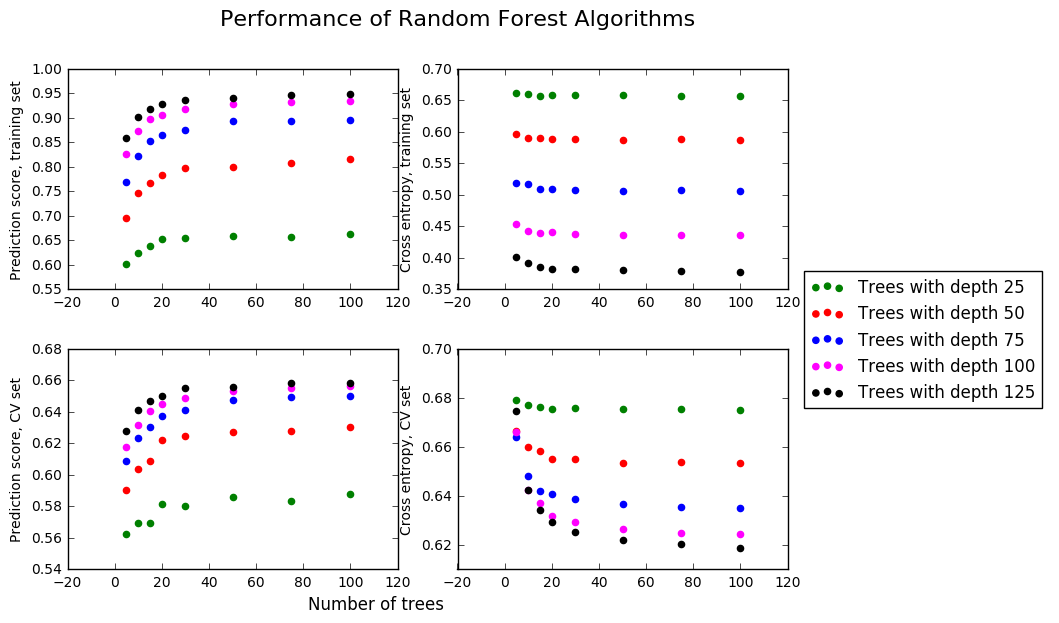

In [32]:
import plotting.rf_plot as rfp

rfp.rf_plot(RFs)

In [33]:
best_ps=RFs.eval_matrix.loc[:,('CV', 'Scores')].idxmax()
best_cv=RFs.eval_matrix.loc[:,('CV', 'Cross entropy')].idxmin()

print('Best depth and tree number with respect to accuracy: ' + str(best_ps))
print('Best depth and tree number with respect to cross entropy: ' + str(best_cv))

Best depth and tree number with respect to accuracy: (125, 75)
Best depth and tree number with respect to cross entropy: (125, 100)


In [34]:
print('Best prediction accuracy: ' + str(RFs.eval_matrix.loc[best_cv,('CV','Scores')]))
print('Best cross entropy: '+ str(RFs.eval_matrix.loc[best_cv,('CV','Cross entropy')]))

Best prediction accuracy: 0.65846334139
Best cross entropy: 0.618612642752


We have improved the accuracy to 65.9 percent, and the cross-entropy to 61.8 percent.

## Interpretation and Recommendations

Given that a logistic regression model was clearly inferior to our random forest classifier, we shall use the latter to draw conclusions. To evaluate players, we can ask our model to predict shot attempts for each player, when only that player is on the ice. Clearly an artificial scenario, but since random forest algorithms split based on one feature at a time, this is the best way to analyze our model. An alternative would be to ask the model what happens for all possible player combinations, but the computation time for this task would be very high.

In [35]:
from sklearn.ensemble import RandomForestClassifier as RFC
import pickle

with open('data/Forest_100_125', 'rb') as input:    
    unpickler = pickle.Unpickler(input)
    myrfc = unpickler.load()

pp = pd.DataFrame(index=AM.NGs, data=np.zeros([900,6]), columns=['Home Corsi', 'Away Corsi',
             'Home RF prediction', 'Away RF prediction', 'Home importance', 'Away importance'])

for p in range(0,900):
    hoi = np.zeros(1800)
    aoi = np.zeros(1800)
    hoi[p] = True
    aoi[p+900] = True 
    pp.iloc[p,0] = AM.compute_Corsi(AM.NGs[p], 'home')
    pp.iloc[p,1] = AM.compute_Corsi(AM.NGs[p], 'away')
    pp.iloc[p,2] = myrfc.predict_proba(hoi)[:,1]
    pp.iloc[p,3] = myrfc.predict_proba(aoi)[:,0]
    pp.iloc[p,4] = myrfc.feature_importances_[p]
    pp.iloc[p,5] = myrfc.feature_importances_[p+900]

First, it is interesting that our model is more cautious than the naive Corsi statistic:

In [36]:
print('Spread of Home Corsi stats: ' + str(pp.loc[:,'Home Corsi'].std()))
print('Spread of Home model prediction: ' + str(pp.loc[:,'Home RF prediction'].std()))

print('Spread of Away Corsi stats: ' + str(pp.loc[:,'Away Corsi'].std()))
print('Spread of Away model prediction: ' + str(pp.loc[:,'Away RF prediction'].std()))

Spread of Home Corsi stats: 0.08621862299310906
Spread of Home model prediction: 0.035440879728936246
Spread of Away Corsi stats: 0.08436779026498906
Spread of Away model prediction: 0.037016983926208495


If we compare the model predictions versus the raw Corsi, we can see that many players do not fall on the $y=x$ line. The model is relatively neutral about a large set of players. There is certainly a smaller class of players that hew to the $y=x$ line. In these cases, the model seems to be agreeing with the raw numbers. Notice that there is hardly any "strong" disagreement: there are really no players near the $y=-x$ line except near the center. In other words, the model is not predicting any "good" players with bad Corsi, or vice versa.

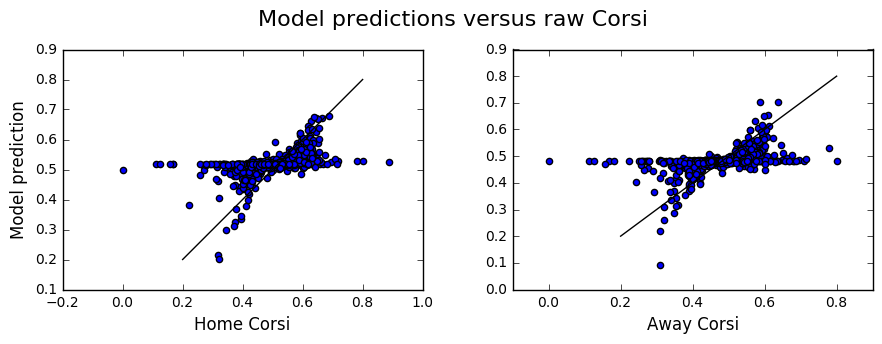

In [37]:
fig = plt.figure()
ax1 = fig.add_axes([.1,.1,0.6,0.6])
ax2 = fig.add_axes([.85,.1,0.6,0.6])

ax1.scatter(pp.loc[:,'Home Corsi'],pp.loc[:, 'Home RF prediction'])
ax2.scatter(pp.loc[:,'Away Corsi'],pp.loc[:, 'Away RF prediction'])

ax1.plot([0.2, 0.8], [0.2, 0.8], color='k', linestyle='-', linewidth=1)
ax2.plot([0.2, 0.8], [0.2, 0.8], color='k', linestyle='-', linewidth=1)

fig.suptitle('Model predictions versus raw Corsi', fontsize=16, x=0.75, y=.8)
ax1.set_xlabel('Home Corsi', fontsize=12)
ax2.set_xlabel('Away Corsi', fontsize=12)
ax1.set_ylabel('Model prediction', fontsize=12)

plt.show()

Now, the `sklearn` package provides a `feature_importances_` method, which allows us to look at how influential a player is within the model. This way, we can weed out spurious findings. It seems reasonable that the model should be relatively neutral about unimportant players, and such players are likely responsible for the data points on the "flat" parts of the above scatter plots.

We can see that, if we restrict ourselves to the "important" players, the model becomes less cautious: 

In [38]:
fi_thr = min(pp.loc[:,'Home importance'].median(), pp.loc[:,'Away importance'].median())

imp_pp = pp[(pp.loc[:,'Home importance']>fi_thr) & (pp.loc[:,'Away importance']>fi_thr)]
print('Spread of Home Corsi stats: ' + str(imp_pp.loc[:,'Home Corsi'].std()))
print('Spread of Home model prediction: ' + str(imp_pp.loc[:,'Home RF prediction'].std()))

print('Spread of Away Corsi stats: ' + str(imp_pp.loc[:,'Away Corsi'].std()))
print('Spread of Away model prediction: ' + str(imp_pp.loc[:,'Away RF prediction'].std()))


Spread of Home Corsi stats: 0.06537348920331643
Spread of Home model prediction: 0.04801247098808603
Spread of Away Corsi stats: 0.06462385733274058
Spread of Away model prediction: 0.05009914157006843


If we plot our model predictions vs. feature importance, we can see that model does in fact get more adventurous for more important players, but there is still a big core of players in the neutral area:

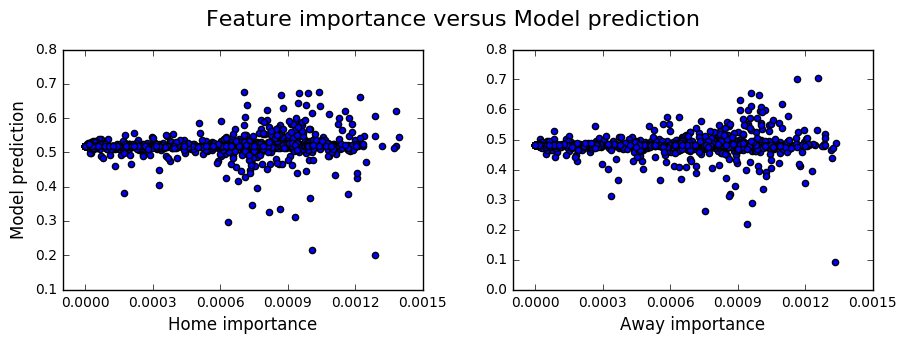

In [39]:
fig = plt.figure()
ax1 = fig.add_axes([.1,.1,0.6,0.6])
ax2 = fig.add_axes([.85,.1,0.6,0.6])

ax1.scatter(pp.loc[:,'Home importance'],pp.loc[:, 'Home RF prediction'])
ax2.scatter(pp.loc[:,'Away importance'],pp.loc[:, 'Away RF prediction'])
ax1.set_xlim([-0.0001,0.0015])
ax2.set_xlim([-0.0001,0.0015])
ax1.set_xticks([0,.0003,.0006,.0009,.0012,.0015])
ax2.set_xticks([0,.0003,.0006,.0009,.0012,.0015])

fig.suptitle('Feature importance versus Model prediction', fontsize=16, x=0.75, y=.8)
ax1.set_xlabel('Home importance', fontsize=12)
ax2.set_xlabel('Away importance', fontsize=12)
ax1.set_ylabel('Model prediction', fontsize=12)

plt.show()

As a check, it would help to see the correlation of importance vs. shots attempted, to see how much of this is a sample size effect. Unsurprisingly, we see that the correlation is pretty strong. 

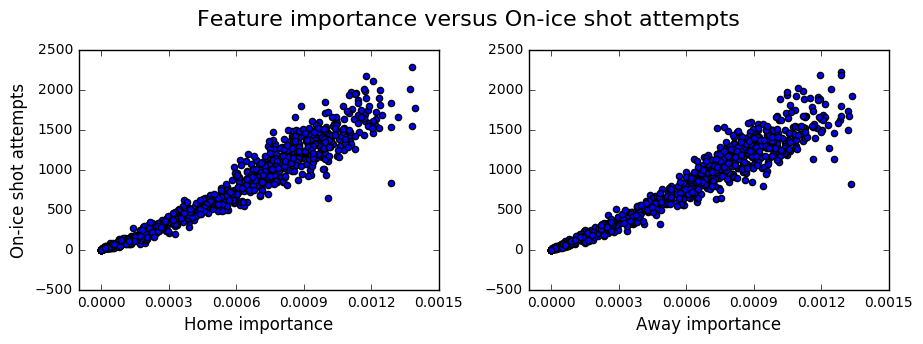

In [40]:
fig = plt.figure()
ax1 = fig.add_axes([.1,.1,0.6,0.6])
ax2 = fig.add_axes([.85,.1,0.6,0.6])

ax1.scatter(pp.loc[:,'Home importance'],pl_atts[0:900])
ax2.scatter(pp.loc[:,'Away importance'],pl_atts[900:1800])
ax1.set_xlim([-0.0001,0.0015])
ax2.set_xlim([-0.0001,0.0015])
ax1.set_xticks([0,.0003,.0006,.0009,.0012,.0015])
ax2.set_xticks([0,.0003,.0006,.0009,.0012,.0015])

fig.suptitle('Feature importance versus On-ice shot attempts', fontsize=16, x=0.75, y=.8)
ax1.set_xlabel('Home importance', fontsize=12)
ax2.set_xlabel('Away importance', fontsize=12)
ax1.set_ylabel('On-ice shot attempts', fontsize=12)

plt.show()

Notice that our side-by-side home and away plots do not look very different in our three previous graphs. It's quite possible that our distinction between home and away performance does not matter much. Interestingly, the model tends to agree about player importance regardless of venue, but the actual predictions themselves are cloudier. 

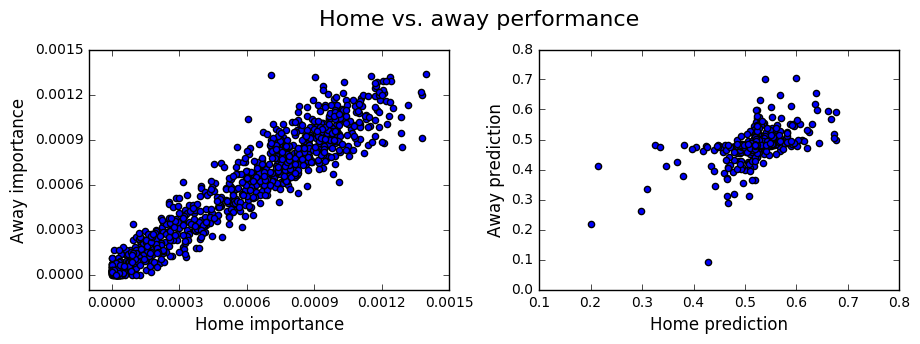

In [41]:
fig = plt.figure()
ax1 = fig.add_axes([.1,.1,0.6,0.6])
ax2 = fig.add_axes([.85,.1,0.6,0.6])

ax1.scatter(pp.loc[:,'Home importance'],pp.loc[:,'Away importance'])
ax2.scatter(pp.loc[:,'Home RF prediction'],pp.loc[:,'Away RF prediction'])
ax1.set_xlim([-0.0001,0.0015])
ax1.set_ylim([-0.0001,0.0015])

fig.suptitle('Home vs. away performance', fontsize=16, x=0.75, y=.8)
ax1.set_xlabel('Home importance', fontsize=12)
ax1.set_ylabel('Away importance', fontsize=12)
ax2.set_xlabel('Home prediction', fontsize=12)
ax2.set_ylabel('Away prediction', fontsize=12)
ax1.set_xticks([0,.0003,.0006,.0009,.0012,.0015])
ax1.set_yticks([0,.0003,.0006,.0009,.0012,.0015])

plt.show()

This might lead us to doubt our model's veracity. If it predicts that certain players only play well at home, is that a real effect, or is this more a reflection of the "randomness" of random forests? One way to check this is to see whether some of the other models we trained agree with our best model. We trained forty forests in total. We will pick the twelve best: those with 30 or more trees, as well as a depth of 75 and above.

In [44]:
pp_100_125 = pp

def pp_produce(n_t, depth):

    with open('data/Forest_' + str(n_t) + '_' + str(depth), 'rb') as input:    
        unpickler = pickle.Unpickler(input)
        myrfc = unpickler.load()

    ppp = pd.DataFrame(index=AM.NGs, data=np.zeros([900,6]), columns=['Home Corsi', 'Away Corsi',
             'Home RF prediction', 'Away RF prediction', 'Home importance', 'Away importance'])

    for p in range(0,900):
        hoi = np.zeros(1800)
        aoi = np.zeros(1800)
        hoi[p] = True
        aoi[p+900] = True 
        ppp.iloc[p,0] = AM.compute_Corsi(AM.NGs[p], 'home')
        ppp.iloc[p,1] = AM.compute_Corsi(AM.NGs[p], 'away')
        ppp.iloc[p,2] = myrfc.predict_proba(hoi)[:,1]
        ppp.iloc[p,3] = myrfc.predict_proba(aoi)[:,0]
        ppp.iloc[p,4] = myrfc.feature_importances_[p]
        ppp.iloc[p,5] = myrfc.feature_importances_[p+900]
    
    return(ppp)

pp_30_125 = pp_produce(30,125) 
pp_50_125 = pp_produce(50,125) 
pp_75_125 = pp_produce(75,125) 
pp_30_100 = pp_produce(30,100) 
pp_50_100 = pp_produce(50,100) 
pp_75_100 = pp_produce(75,100) 
pp_100_100 = pp_produce(100,100) 
pp_30_75 = pp_produce(30,75) 
pp_50_75 = pp_produce(50,75) 
pp_75_75 = pp_produce(75,75) 
pp_100_75 = pp_produce(100,75) 


In [45]:
pp_d75 = pd.concat([pp_30_75,pp_50_75,pp_75_75,pp_100_75], keys = ['30 trees','50 trees','75 trees','100 trees'])
pp_d100 = pd.concat([pp_30_100,pp_50_100,pp_75_100,pp_100_100], keys = ['30 trees','50 trees','75 trees','100 trees'])
pp_d125 = pd.concat([pp_30_125,pp_50_125,pp_75_125,pp_100_125], keys = ['30 trees','50 trees','75 trees','100 trees'])

pp_big = pd.concat([pp_d75, pp_d100, pp_d125], keys= ['Depth 75','Depth 100','Depth 125'])

In [46]:
pp_stat = pd.DataFrame(index=AM.NGs, data=np.zeros([900,8]), columns=['Home RF prediction mean',
    'Away RF prediction mean', 'Home importance mean', 'Away importance mean', 'Home RF prediction std', 
    'Away RF prediction std', 'Home importance std', 'Away importance std'])

for p in AM.NGs:
    h_imps = []
    a_imps = []
    h_pred = []
    a_pred = []
    for n_t in [30,50,75,100]:
        for dp in [75,100,125]:
            pdf = pp_big.loc['Depth '+ str(dp), str(n_t) + ' trees'].loc[p]
            h_imps.append(pdf['Home importance'])
            a_imps.append(pdf['Away importance'])
            h_pred.append(pdf['Home RF prediction'])
            a_pred.append(pdf['Away RF prediction'])
            pp_stat.loc[p,'Home RF prediction mean'] = np.mean(h_pred)
            pp_stat.loc[p,'Home RF prediction std'] = np.std(h_pred)/np.sqrt(12)
            pp_stat.loc[p,'Away RF prediction mean'] = np.mean(a_pred)
            pp_stat.loc[p,'Away RF prediction std'] = np.std(a_pred)/np.sqrt(12)
            pp_stat.loc[p,'Home importance mean'] = np.mean(h_imps)
            pp_stat.loc[p,'Home importance std'] = np.std(h_imps)/np.sqrt(12)
            pp_stat.loc[p,'Away importance mean'] = np.mean(a_imps)
            pp_stat.loc[p,'Away importance std'] = np.std(a_imps)/np.sqrt(12)


So we have gathered information on the statistics of both feature importance and model predictions. How much does importance vary between the twelve models? Below we've plotted the mean importance vs. importance in the best model (home only; away graph looks similar). As well, we plotted the standard error of importance, with the axis scaled to compare with the left. Clearly there is a tight correlation between the best model and the twelve "pretty good" models. 

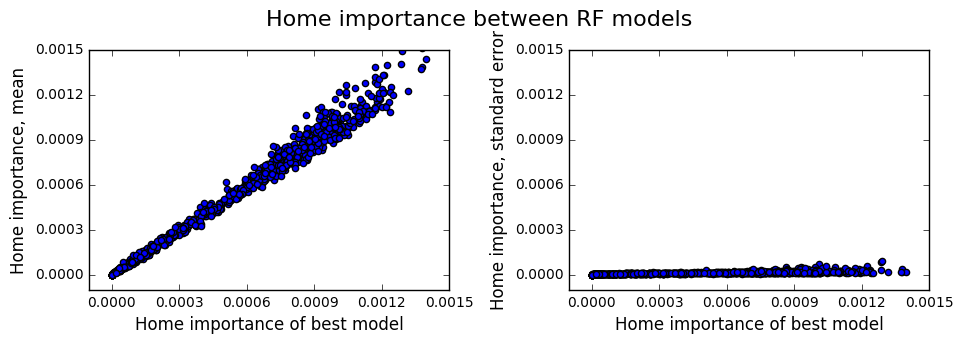

In [47]:
fig = plt.figure()
ax1 = fig.add_axes([.1,.1,0.6,0.6])
ax2 = fig.add_axes([.9,.1,0.6,0.6])
ax1.scatter(pp.loc[:,'Home importance'],pp_stat.loc[:,'Home importance mean'])
ax2.scatter(pp.loc[:,'Home importance'],pp_stat.loc[:,'Home importance std'])

ax1.set_xlim([-0.0001,0.0015])
ax2.set_xlim([-0.0001,0.0015])
ax1.set_ylim([-0.0001,0.0015])
ax2.set_ylim([-0.0001,0.0015])

fig.suptitle('Home importance between RF models', fontsize=16, x=0.75, y=.8)
ax1.set_xlabel('Home importance of best model', fontsize=12)
ax2.set_xlabel('Home importance of best model', fontsize=12)
ax1.set_ylabel('Home importance, mean', fontsize=12)
ax2.set_ylabel('Home importance, standard error', fontsize=12)
ax1.set_xticks([0,.0003,.0006,.0009,.0012,.0015])
ax1.set_yticks([0,.0003,.0006,.0009,.0012,.0015])
ax2.set_xticks([0,.0003,.0006,.0009,.0012,.0015])
ax2.set_yticks([0,.0003,.0006,.0009,.0012,.0015])

plt.show()

We repeat this for the actual model predictions. Will they vary much between models? The answer appears to be no.

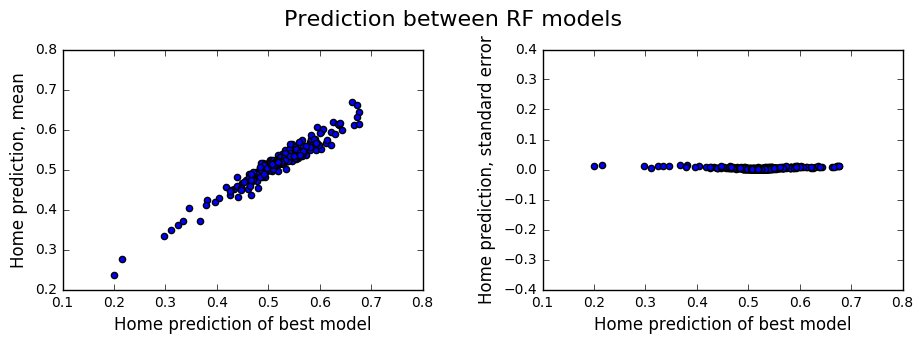

In [48]:
fig = plt.figure()
ax1 = fig.add_axes([.1,.1,0.6,0.6])
ax2 = fig.add_axes([.9,.1,0.6,0.6])
ax1.scatter(pp.loc[:,'Home RF prediction'],pp_stat.loc[:,'Home RF prediction mean'])
ax2.scatter(pp.loc[:,'Home RF prediction'],pp_stat.loc[:,'Home RF prediction std'])

ax1.set_ylim([0.2,0.8])
ax2.set_ylim([-0.4,0.4])

fig.suptitle('Prediction between RF models', fontsize=16, x=0.75, y=.8)
ax1.set_xlabel('Home prediction of best model', fontsize=12)
ax2.set_xlabel('Home prediction of best model', fontsize=12)
ax1.set_ylabel('Home prediction, mean', fontsize=12)
ax2.set_ylabel('Home prediction, standard error', fontsize=12)

plt.show()

The vertical axis in the above scatter plot of the standard error is scaled to be comparable to that of the mean. There does not appear to any variation at that scaling. However, if one increases the scaling, one sees that there is a clear dip around 0.5. This is reasonable: the models are fairly confident about the neutral players. But there is more disagreement regarding players with relatively extreme predictions:  

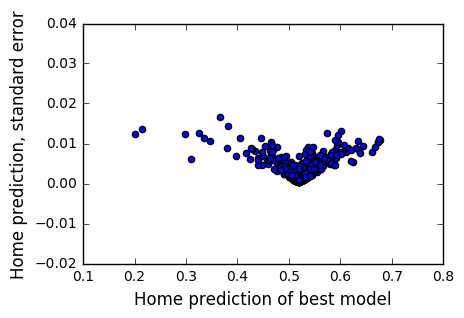

In [49]:
fig = plt.figure()
ax = fig.add_axes([.1,.1,0.6,0.6])
ax.scatter(pp.loc[:,'Home RF prediction'],pp_stat.loc[:,'Home RF prediction std'])

ax.set_xlabel('Home prediction of best model', fontsize=12)
ax.set_ylabel('Home prediction, standard error', fontsize=12)

plt.show()

The main objective of this report was to identify players that overperform or underperform their raw Corsis. We wanted to find "hidden gems" (or "hidden duds"). However, when one looks at the "Model prediction vs. raw Corsi" plots above, it becomes clear that we perhaps should revise our objectives somewhat. The strength of our model does not lie in finding special players; rather, it lies in identifying players who are *not* special. There are a large number of data point that cluster around the line $y=0.5$. Such players may have Corsi far from 0.5, but the model says: "No, don't believe that - those players are actually average!".

In order to quantify this, we compare the fraction of players with non-extreme Corsi (defined as between 0.45 and 0.55) to the fraction of players that the model considers non-extreme. There is a big difference - around 46 percent of players have non-extreme Corsi, but that number jumps to 89 percent according to the model:

In [50]:
mid_corsi = sum((pp.loc[:, 'Home Corsi'] < 0.55) & (pp.loc[:, 'Home Corsi'] > 0.45))/900 
mid_model = sum((pp.loc[:, 'Home RF prediction'] < 0.55) & (pp.loc[:, 'Home RF prediction'] > 0.45))/900 

print("Percentage of players with Home Corsi between 0.45 and 0.55: " + str(mid_corsi*100))
print("Percentage of players with Model predictions between 0.45 and 0.55: " + str(mid_model*100))

Percentage of players with Home Corsi between 0.45 and 0.55: 46.3333333333
Percentage of players with Model predictions between 0.45 and 0.55: 89.0


We see below that most players have a model prediction much closer to mean than their Corsi. Interestingly this effect is enhanced for away players. One can see from the graphs below, that there is a large component of points hugging the $y=0$ line.

In [51]:
home_c_dev = abs(pp.loc[:, 'Home Corsi'] - pp.loc[:, 'Home Corsi'].mean())
away_c_dev = abs(pp.loc[:, 'Away Corsi'] - pp.loc[:, 'Away Corsi'].mean())
home_m_dev = abs(pp.loc[:, 'Home RF prediction'] - pp.loc[:, 'Home RF prediction'].mean())
away_m_dev = abs(pp.loc[:, 'Away RF prediction'] - pp.loc[:, 'Away RF prediction'].mean())

print("Average fraction of deviations from mean for model prediction relative to Corsi: " + str(np.mean(home_m_dev/home_c_dev)))
print("Same but for away: " + str(np.mean(away_m_dev/away_c_dev)))

Average fraction of deviations from mean for model prediction relative to Corsi: 0.5868344305277602
Same but for away: 0.3807335635781127


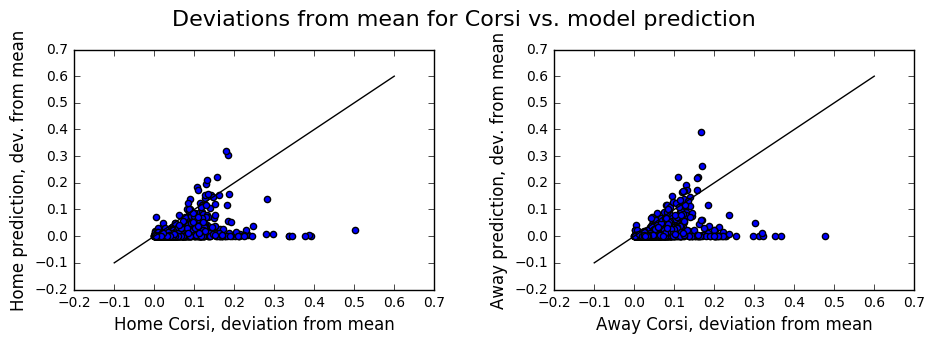

In [52]:
home_c_dev = abs(pp.loc[:, 'Home Corsi'] - pp.loc[:, 'Home Corsi'].mean())
away_c_dev = abs(pp.loc[:, 'Away Corsi'] - pp.loc[:, 'Away Corsi'].mean())
home_m_dev = abs(pp.loc[:, 'Home RF prediction'] - pp.loc[:, 'Home RF prediction'].mean())
away_m_dev = abs(pp.loc[:, 'Away RF prediction'] - pp.loc[:, 'Away RF prediction'].mean())

fig = plt.figure()
ax1 = fig.add_axes([.1,.1,0.6,0.6])
ax2 = fig.add_axes([.9,.1,0.6,0.6])
ax1.scatter(home_c_dev, home_m_dev)
ax2.scatter(away_c_dev, away_m_dev)
ax1.plot([-0.1,0.6],[-0.1,0.6], color='black')
ax2.plot([-0.1,0.6],[-0.1,0.6], color='black')

fig.suptitle('Deviations from mean for Corsi vs. model prediction', fontsize=16, x=0.75, y=.8)
ax1.set_xlabel('Home Corsi, deviation from mean', fontsize=12)
ax1.set_ylabel('Home prediction, dev. from mean', fontsize=12)
ax2.set_xlabel('Away Corsi, deviation from mean', fontsize=12)
ax2.set_ylabel('Away prediction, dev. from mean', fontsize=12)

plt.show()

Our model is essentially acting like a filter: it is telling us which players have "false" Corsis. We would like to compile an objective list of which players this refers to. We set a threshold of 30 percent: any player whose model deviation is less than 30 percent of their Corsi deviation we will filter out (for both home and away). One could argue this is a conservative threshold, but it turns out that it still filters out almost 60 percent of the players:

In [53]:
filt_false = (home_m_dev < 0.3*home_c_dev) & (away_m_dev < 0.3*away_c_dev)
print("Number of players filtered out: "+ str(sum( filt_false )))

Number of players filtered out: 536


In [54]:
pp_false = pp[filt_false]
pp_false.to_csv("false_Corsi.csv")
pp_false.head()

,Home Corsi,Away Corsi,Home RF prediction,Away RF prediction,Home importance,Away importance
AARON EKBLAD,0.578270,0.527367,0.525878,0.485489,0.001017,0.001056
AARON NESS,0.525641,0.532710,0.519370,0.480630,0.000077,0.000099
ADAM CLENDENING,0.541841,0.433846,0.519370,0.480630,0.000396,0.000365
ADAM HENRIQUE,0.466905,0.452698,0.519370,0.479915,0.000616,0.000841
ADAM PELECH,0.384615,0.415584,0.519318,0.480630,0.000200,0.000074


Above, we had filtered out the players that have an inflated Corsi for both home and away. We have saved these 536 players in a data file.

Conversely, we would also like to see which players do not have an inflated Corsi. For this threshold, we have settled on a threshold of 0.7. It turns out that players with robust Corsi is much smaller:

In [55]:
filt_robust = (home_m_dev > 0.7*home_c_dev) & (away_m_dev > 0.7*away_c_dev)
print("Number of players with robust Corsi: "+ str(sum( filt_robust )))

Number of players with robust Corsi: 24


In [56]:
pp_robust = pp[filt_robust]
pp_robust.to_csv("robust_Corsi.csv")
pp_robust

,Home Corsi,Away Corsi,Home RF prediction,Away RF prediction,Home importance,Away importance
ALEX OVECHKIN,0.629032,0.602395,0.661812,0.594076,0.001223,0.001001
ANDY GREENE,0.391840,0.353275,0.440992,0.343359,0.000941,0.000888
CALVIN DE HAAN,0.502729,0.418784,0.517436,0.412669,0.001147,0.000990
DAN BOYLE,0.554622,0.521199,0.557066,0.528319,0.000967,0.001037
ERIK KARLSSON,0.592267,0.530650,0.621303,0.530758,0.001380,0.001195
GREGORY CAMPBELL,0.389034,0.310049,0.427933,0.092396,0.000709,0.001332
JAROME IGINLA,0.513912,0.522835,0.529333,0.554642,0.000827,0.001084
JARRET STOLL,0.322464,0.308750,0.200244,0.218127,0.001286,0.000940
KARL ALZNER,0.440974,0.419666,0.439379,0.394267,0.001207,0.001229
KRIS VERSTEEG,0.623418,0.610601,0.637383,0.654805,0.000981,0.000960


If we look at the Corsis of the robust players, we see that they are relatively well spread out:

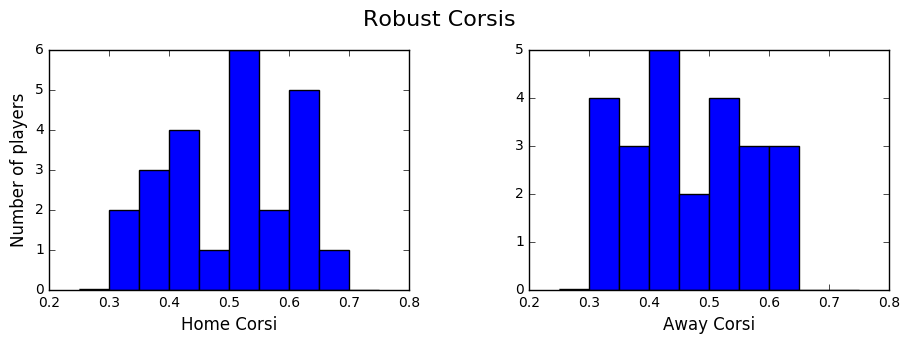

In [57]:
fig = plt.figure()
ax1 = fig.add_axes([.1,.1,0.6,0.6])
ax2 = fig.add_axes([.9,.1,0.6,0.6])
ax1.hist(pp_robust['Home Corsi'], bins=[0.25, 0.3,0.35,0.4,.45,.5,.55,.6,.65,.7,.75])
ax2.hist(pp_robust['Away Corsi'], bins=[0.25, 0.3,0.35,0.4,.45,.5,.55,.6,.65,.7,.75])

fig.suptitle('Robust Corsis', fontsize=16, x=0.75, y=.8)
ax1.set_xlabel('Home Corsi', fontsize=12)
ax1.set_ylabel('Number of players', fontsize=12)
ax2.set_xlabel('Away Corsi', fontsize=12)

plt.show()

We should also check that these robust players have a relatively high importance. We can see that all but one player (Reid Boucher) are above-median importance.

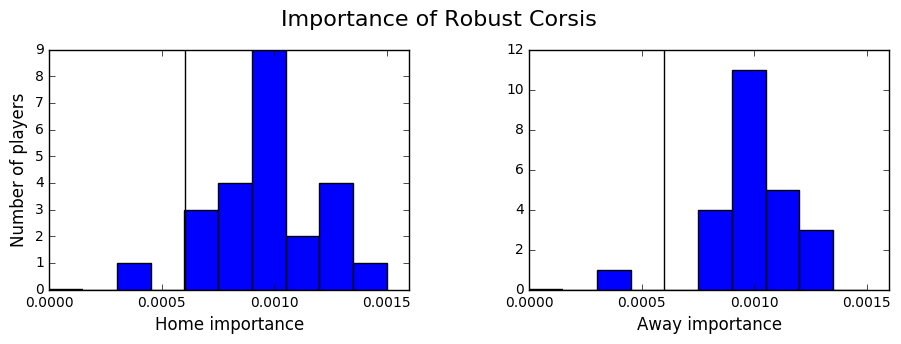

In [58]:
fig = plt.figure()
ax1 = fig.add_axes([.1,.1,0.6,0.6])
ax2 = fig.add_axes([.9,.1,0.6,0.6])
ax1.hist(pp_robust['Home importance'], bins= np.arange(0, 0.0015, 0.00015))
ax2.hist(pp_robust['Away importance'], bins= np.arange(0, 0.0015, 0.00015))

fig.suptitle('Importance of Robust Corsis', fontsize=16, x=0.75, y=.8)
ax1.set_xlabel('Home importance', fontsize=12)
ax1.set_ylabel('Number of players', fontsize=12)
ax2.set_xlabel('Away importance', fontsize=12)
ax1.set_xticks(np.arange(0,0.002,0.0005))
ax2.set_xticks(np.arange(0,0.002,0.0005))
ax1.axvline(pp['Home importance'].median(), color="black")
ax2.axvline(pp['Away importance'].median(), color="black")

plt.show()

Finally, we want to see how many of these 24 players were to survive if we were to raise the threshold from 0.7 to 1.0. In other words, which players have model predictions that are actually *stronger* than their raw Corsi? The answer: only nine. Of these, five players have already poor Corsis, but even worse model predictions. One player, Wayne Simmonds, has a good Corsi, but is even better according to the model. One player, Kyle Palmieri, had mediocre Corsi, but is very well rated by the model. The remaining two players, Calvin de Haan and Matt Niskanen, are interesting in that their home and away splits are different. The model says they are better at home than their Corsi ratings indicate, but worse away from home. Perhaps these two are particularly susceptible to the mental difficulties of a hostile playing environment. 

In [59]:
filt_hidden = (home_m_dev > 1*home_c_dev) & (away_m_dev > 1*away_c_dev)
print("Number of players with model prediction more extreme than Corsi: "+ str(sum( filt_hidden )))

Number of players with model prediction more extreme than Corsi: 9


In [60]:
pp_hidden = pp[filt_hidden]
pp_hidden.to_csv("hidden_Corsi.csv")
pp_hidden

,Home Corsi,Away Corsi,Home RF prediction,Away RF prediction,Home importance,Away importance
CALVIN DE HAAN,0.502729,0.418784,0.517436,0.412669,0.001147,0.000990
JARRET STOLL,0.322464,0.308750,0.200244,0.218127,0.001286,0.000940
KARL ALZNER,0.440974,0.419666,0.439379,0.394267,0.001207,0.001229
KYLE PALMIERI,0.508411,0.519875,0.593069,0.550812,0.000809,0.000948
LUKE GLENDENING,0.370331,0.339138,0.310290,0.334522,0.000932,0.001011
MATT NISKANEN,0.509485,0.474785,0.526507,0.458844,0.000994,0.001184
NICK SCHULTZ,0.412831,0.394309,0.379141,0.378369,0.001168,0.001027
PAUL GAUSTAD,0.345018,0.320312,0.297956,0.262367,0.000633,0.000754
WAYNE SIMMONDS,0.638102,0.588738,0.676178,0.592495,0.001040,0.001008


As one last exercise, we would like to consider the two players that inspired this report: Jonathan Toews and Jake Virtanen.

In [61]:
print(pp.loc['JONATHAN TOEWS'])

Home Corsi            0.555345
Away Corsi            0.519820
Home RF prediction    0.534702
Away RF prediction    0.481566
Home importance       0.001050
Away importance       0.001005
Name: JONATHAN TOEWS, dtype: float64


In [62]:
print(pp.loc['JAKE VIRTANEN'])

Home Corsi            0.534517
Away Corsi            0.528440
Home RF prediction    0.514376
Away RF prediction    0.483489
Home importance       0.000472
Away importance       0.000448
Name: JAKE VIRTANEN, dtype: float64


As expected, the model's estimation of Virtanen is lower than the Corsi indicates. His initially positive home rating is actually closer to the mean, according to the model. His away rating meanwhile, while also initially positive, is actually below the mean. 

Jonathan Toews, on the other hand, defies our intuition. His ratings also suffer according to our model. Just like Virtanen his home rating regresses to the mean, and his away rating passes below the mean.

### Summary of Findings

1. It is possible to train a random forest algorithm that predicts shot attempt behavior better than raw Corsi numbers. The accuracy of this algorithm on an independent cross-validation set is 65.8 percent, while that of the raw Corsis, using logistic regression, is 62.2 percent.

2. Our best random forest algorithm required 100 trees, each at a depth of 125. 

3. Our findings seemed relatively robust to different hyper-parameters, provided they were both relatively high. Player ratings did not change drastically while increaing tree number from 30 to 100, or depth from 75 to 125.

4. For the vast majority of players, the algorithm rating is weaker than their Corsi rating. We filtered out players whose algorithm rating, both home and away, was less than 30 percent as strong as their Corsi. This accounted for 536 of the 900 players who skated in the 2015-2016 season.

5. We were able to identify 24 players whose ratings were robust. That is, the algorithm rated them at least 70 percent as strongly as their Corsi. The original ratings of these players ranged across the spectrum.

6. 9 players had model ratings stronger than their Corsi. Of these, Wayne Simmonds and Kyle Palmieri are better players than their Corsis indicate. Jarrett Stoll, Luke Glendening, Nick Schultz, Paul Gaustad, and Karl Alzner are worse. Calvin de Haan and Matt Niskanen are better at home, but worse away from home.

## Appendix: summary of Python and data files

The amount of Python code I used is too large to dump into this report, so I will list the files here with short descriptions. All code is available at the github repo:

    http://www.github.com/darraghrooney/Springboard_Capstone/

    /scraping/

        roster_scrape.py        
        directory_build.py      
        es_scrape.py            
        salary_fill.py          
        report_downloader.py        
        attempt_scrape.py       
    
    /wrangling/

        attempt_manager.py      
        summary_manager.py      
        data_split.py           
    
    /small_logistic/
    
        feature_assemble.py     
        small_logistic.py       

    /big_logistic/
    
        big_logistic.py         

    /forests/
    
        rafo.py          

    /plotting/
    
        plotting.py          
        log_plot.py          
        big_log_plot.py          
        rf_plot.py          


Additionally, there were a number of data files generated (some .csv, some .npz). The random forest pickled files are not kept in the repository because they are too big.

    /data/
        Big_Roster.csv
        Directory.csv
        Summary.csv
        Attempts.npz
        Training.npz
        CV.npz
        TrainCorsis.csv
        CVCorsis.csv
        false_Corsi.csv
        robust_Corsi.csv
        hidden_Corsi.csv